**Vulnérabilité aux pollutions et caractéristiques sociodémographiques des territoires**


Par Réda Bounechar, Juliette Lesné et Aurélian Moge - 2025

**Introduction**

L'objectif de ce notebook est d'étudier le rapport entre, d'une part, les caractéristiques sociodémographiques des communes d'Ile-de-France (superficie, densité, composition socioprofessionnelle, revenu médian, dotation en infrastructures...) et, d'autre part, l'exposition de leur population à différentes pollutions. Plus exactement, nous étudions les conséquences mesurables de la dégradation de l'environnement local, sur la qualité de l'air principalement ; ces conséquences doivent également être discriminantes localement, c'est-à-dire non uniformément établies sur la région étudiée, raison pour laquelle les données liées à l'évolution des températures n'ont pas été prises en compte, quoique l'exposition différenciée aux conséquences du changement climatique puisse faire l'objet d'un autre travail.

In [1]:
!pip install openpyxl
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [contextily]9 [geopy]io]


In [2]:
import requests
import zipfile
import openpyxl

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import contextily

import json
from shapely.geometry import shape

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Partie 1 : Importation des données**

Dans cette partie, nous importons les données dont nous avons besoin. 

En premier lieu, on importe les données tirées de Géorisques qui nous intéressent : fichier des installations industrielles rejetant des polluants ; volume des rejets industriels par établissement (en m3) ; émissions de produits polluant l'eau, l'air et le sol (en kg) ; production de déchets dangereux (en tonnes).

En second lieu, on importe les données des communes : les coordonnées géographiques d'une part, les données sociodémographiques d'autre part. 


*1.1. Données de pollution industrielle*

On importe le fichier des établissements industriels puis celui des rejets associés, avant de les fusionner. Dans un second temps, on construit un fichier agrégé par commune, qui nous donne une liste des communes (réduite à celles qui ont des établissements polluant), le nombre d'établissements polluant dans celle-ci et la somme des rejets de ces derniers. A noter que ces trois catégories sont répétées trois fois pour prendre en compte les rejets isolés, mais aussi ceux raccordés et le total des rejets. 

Ensuite, on importe le fichier des émissions de polluants et celui des productions de déchets dangereux, qu'on regroupe selon l'établissement puis selon la commune afin d'avoir le nombre d'établissements concernés dans chaque commune.

Enfin, on fusionne tout et on trouve un fichier qui compte, pour chaque commune, le nombre d'établissements qui dépasse chaque seuil. 

In [3]:
### Etablissements industriels

# On télécharge le dossier des installations industrielles rejetant des polluants (2024)
url_industries_polluantes = "https://files.georisques.fr/irep/2023.zip"
response_industries_polluantes = requests.get(url_industries_polluantes)

# On enregistre le dossier localement
with open("Industries_polluantes.xlsx", "wb") as f:
    f.write(response_industries_polluantes.content)

# On importe le fichier répertoriant les établissements polluants (qui est une liste des établissements)
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/etablissements.csv") as f:
        industries_polluantes = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee dès maintenant (pour harmoniser ensuite)
industries_polluantes = industries_polluantes.rename(columns={"code_insee" : "insee"})

In [4]:
### Rejets (pour chaque établissement listé dans industries_polluantes)

# On import le fichier des rejets
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/rejets.csv") as f:
        rejets = pd.read_csv(f, sep=None, engine='python')

# On renomme également la colonne insee
rejets = rejets.rename(columns = {"code_insee" : "insee"})

# On fusionne les deux tables
etablissements_rejets = pd.merge(industries_polluantes, rejets, on=["identifiant", "nom_etablissement", "code_postal", "insee",
"commune", "code_departement", "departement", "code_region", "region"], how="inner")

# On regroupe par la commune et on enregistre les pollutions (total des rejets ET nombre d'établissements)
etablissements_rejets_agr = etablissements_rejets.groupby("insee").agg(
    rejets_isoles=("rejet_isole_m3_par_an", "sum"),
    nb_etablissements_isoles=("rejet_isole_m3_par_an", "count"),
    rejets_raccordes=("rejet_raccorde_m3_par_an", "sum"),
    nb_etablissements_raccordes=("rejet_raccorde_m3_par_an", "count")).reset_index()

# On fait, pour chaque commune, la somme des rejets raccordés et isolés pour les deux colonnes concernées
etablissements_rejets_agr["rejets_tot"] = etablissements_rejets_agr["rejets_isoles"] + etablissements_rejets_agr["rejets_raccordes"]
etablissements_rejets_agr["nb_etablissements_rejets_tot"] = etablissements_rejets_agr["nb_etablissements_isoles"] + etablissements_rejets_agr["nb_etablissements_raccordes"]

In [5]:
### Emissions

# On importe le fichier des émissions
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/emissions.csv") as f:
        emissions = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee
emissions = emissions.rename(columns = {"code_insee" : "insee"})

# On convertit en numériques les quantités d'émission (pour distinguer les nombres des lignes "inférieur au seuil")
emissions["quantite"] = pd.to_numeric(emissions["quantite"], errors="coerce")

# On supprime les lignes où il est écrit "inférieur au seuil" et qui sont devenues NAs
emissions = emissions.dropna(axis=0)

# On regroupe par identifiant d'établissement et on affiche la commune pour conserver l'information
emissions_agr = (
    emissions
    .groupby("identifiant")
    .agg(
        insee=("insee", "first"),
        nombre_emissions=("identifiant", "count")
    )
    .reset_index()
)

# On regroupe ensuite par commune : on compte le nombre d'établissements, puis le nombre d'établissements par "gravité" des émissions
# (une seule dans l'établissement, ou 2, ou 3, ou 4 et plus)
emissions_agr_agr = (
    emissions_agr
    .groupby("insee")
    .agg(
        nombre_etablissements_emissions=("identifiant", "count"),
        nombre_etablissements_emissions_2_plus=("nombre_emissions", lambda x: (x >= 2).sum()),
        nombre_etablissements_emissions_3_plus=("nombre_emissions", lambda x: (x >= 3).sum()),
    )
    .reset_index()
)

In [6]:
### Dechets

# On importe le fichier des déchets dangereux
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/Prod_dechets_dangereux.csv") as f:
        dechets_dangereux = pd.read_csv(f, sep=None, engine='python')

# Pareil, on renomme la colonne insee, et on supprime les NAs dans les quantités
dechets_dangereux = dechets_dangereux.rename(columns = {"code_insee" : "insee"})
dechets_dangereux["quantite"] = pd.to_numeric(dechets_dangereux["quantite"], errors="coerce")
dechets_dangereux = dechets_dangereux.dropna(axis=0, subset = ["quantite"])

# On fait exactement la même chose pour l'agrégation
dechets_dangereux_agr = (
    dechets_dangereux
    .groupby("identifiant")
    .agg(
        insee=("insee", "first"),
        nombre_dechets=("identifiant", "count")
    )
    .reset_index()
)

dechets_dangereux_agr_agr = (
    dechets_dangereux_agr
    .groupby("insee")
    .agg(
        nombre_etablissements_dechets=("identifiant", "count"),
        nombre_etablissements_dechets_2_plus=("nombre_dechets", lambda x: (x >= 2).sum()),
        nombre_etablissements_dechets_3_plus=("nombre_dechets", lambda x: (x >= 3).sum()),
    )
    .reset_index()
)

In [7]:
### Fusion des quatre jeux de données

georisques = (
    etablissements_rejets_agr
    .merge(emissions_agr_agr, on="insee", how="outer")
    .merge(dechets_dangereux_agr_agr, on="insee", how="outer")
)

*1.2. Données géographiques et sociodémographiques*

In [8]:
#### On importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9..."


In [9]:
# On duplique les colonnes Paris, Lyon et Marseille pour les arrondissements

communes_ext = communes.copy()

## Pour Paris

# On enregistre la ligne de Paris
communes_paris = communes_ext[communes_ext["insee"] == "75056"]

# On la copie 20 fois
communes_paris_20 = communes_paris.loc[communes_paris.index.repeat(20)].copy()

# On change uniquement la colonne insee (on changera les autres plus tard selon les besoins)
communes_paris_20["insee"] = [f"751{str(i).zfill(2)}" for i in range(1, 21)]    #f" permet d'insérer une variable dans une chaîne, str(i) convertit les chiffres et zfill ajoute des zéros à gauche pour le code insee

# On ajoute nos lignes au df original
i = communes_paris.index[0]         # on récupère la position de la ligne de Paris
communes_ext = pd.concat(                       # on assemble deux df aux colonnes identiques via pd.concat
    [communes_ext.iloc[:i+1], communes_paris_20, communes_ext.iloc[i+1:]],       # toutes nos lignes jusqu'à Paris - puis Paris - puis tout le reste 
    ignore_index=True
)

## Idem pour Lyon
communes_lyon = communes_ext[communes_ext["insee"] == "69123"]
communes_lyon_20 = communes_lyon.loc[communes_lyon.index.repeat(9)].copy()
communes_lyon_20["insee"] = [f"6938{str(i)}" for i in range(1, 10)]

j = communes_lyon.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:j+1], communes_lyon_20, communes_ext.iloc[j+1:]],
    ignore_index=True
)

## Et pour Marseille
communes_marseille = communes_ext[communes_ext["insee"] == "13055"]
communes_marseille_20 = communes_marseille.loc[communes_marseille.index.repeat(16)].copy()
communes_marseille_20["insee"] = [f"132{str(i).zfill(2)}" for i in range(1, 17)]

k = communes_marseille.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:k+1], communes_marseille_20, communes_ext.iloc[k+1:]],
    ignore_index=True
)

In [10]:
### On fait une première fusion entre les communes et les pollutions industrielles

# On fait la jointure (en ne conservant que les communes qui sont dans les deux df, ie celles qui ont des rejets identifiés)
communes_rejets = pd.merge(communes_ext, georisques, on="insee", how = "inner")

# Conversion du fichier au format GeoPandas
communes_rejets = gpd.GeoDataFrame(communes_rejets, geometry='geometry')

# On crée un df avec les communes et une variable polluée ou non (binaire)
communes_statut = communes_ext.copy()
communes_statut["Polluee"] = communes_statut["insee"].isin(communes_rejets["insee"])

# On regarde combien on en a (4 752 polluées parmi 35 000 : environ 13-14%)
print(communes_statut["Polluee"].sum(), communes_ext.shape)

4752 (35000, 5)


In [11]:
# Avant de fusionner etablissements_rejets et communes_statut, on vérifie qu'il n'y a pas d'incohérence
print(
    (set(etablissements_rejets["insee"].astype(str)) - set(communes_statut["insee"].astype(str))),
    (set(communes_statut["insee"].astype(str)) - set(etablissements_rejets["insee"].astype(str)))
    )

# On supprime les codes en trop
codes_pollution = set(etablissements_rejets["insee"].astype(str))
codes_communes  = set(communes_statut["insee"].astype(str))
codes_non_trouves = codes_pollution - codes_communes
codes_arrondissements = {c for c in codes_non_trouves if c.startswith(("75", "13", "69"))}
etablissements_rejets = etablissements_rejets[
    ~etablissements_rejets["insee"].astype(str).isin(codes_non_trouves - codes_arrondissements)
]

{'61356', '85212', '33267', '27676', '49276', '49204', '50354', '01154', '79264', '73002', '50163', '85217', '49274', '49039', '74268', '16274'} {'21325', '06144', '79091', '01237', '80273', '67491', '31246', '32231', '61133', '01254', '24269', '60643', '89400', '32172', '79283', '62207', '76483', '54059', '70081', '09047', '47040', '65328', '11175', '87088', '38295', '41028', '17158', '17064', '17474', '67178', '63169', '61046', '59462', '91339', '82032', '76069', '63172', '02579', '78423', '95256', '39269', '10267', '25276', '70523', '37131', '85209', '07020', '58296', '18036', '08273', '86254', '14077', '55416', '78125', '45316', '61308', '57501', '2B096', '67195', '65069', '89065', '19046', '57095', '95352', '21583', '25211', '65077', '63114', '80033', '63097', '77030', '80297', '01439', '59409', '27256', '28229', '24050', '33502', '72183', '57516', '17290', '47161', '18118', '52336', '21172', '09068', '06051', '04084', '95142', '25384', '88474', '80134', '59332', '34111', '57536',

In [12]:
# On fusionne pour Paris, Lyon et Marseille (dans une colonne à part au cas où)
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee"]
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["13203", "13205", "13208", "13209", "13210", "13211", "13214", "13215", "13216"],
#"13055").astype(str)
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["69383", "69384", "69387", "69388", "69389"],"69123").astype(str)
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["75101", "75109", "75111", "75112", "75115"],"75056").astype(str)

In [13]:
# On fusionne georisques et communes_statut (ce qui étend communes_statut avec, au-delà du statut, des précisions sur les pollutions)
communes_statut = pd.merge(communes_statut, georisques, on = "insee", how = "left")

In [14]:
#### On importe le dossier complet de l'INSEE pour apparier avec des données "sociales"

# On télécharge le dossier qui contient notre csv
url_complet = "https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip"
zip_path = "dossier_complet.zip" 

# On enregistre le fichier localement
response = requests.get(url_complet)
with open(zip_path, "wb") as f:
    f.write(response.content)

# On importe notre fichier avec Pandas (et on l'appelle complet_insee)
csv_complet_insee = "dossier_complet.csv" 
with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_complet_insee) as f:
        complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')

/tmp/ipykernel_7602/1042689086.py:16: DtypeWarning: Columns (0,1701,1702) have mixed types. Specify dtype option on import or set low_memory=False.
  complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')


In [15]:
# On renomme la colonne CODGEO en insee (comme tous les autres df)
complet_insee = complet_insee.rename(columns={"CODGEO" : "insee"})

# Puis on la convertit en chaine de caractères
complet_insee["insee"] = complet_insee["insee"].astype(str).str.zfill(5)

In [16]:
#### On fait à nouveau la jointure avec notre df précédent

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_statut['insee'] = communes_statut['insee'].astype(str).str.zfill(5)    # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
complet_insee['insee'] = complet_insee['insee'].astype(str).str.zfill(5)

# On fusionne
communes_complet = pd.merge(communes_statut, complet_insee, on="insee") # on obtient un tableau à 1997 colonnes (et 34 976 lignes)
communes_complet.shape

(34976, 1993)

In [17]:
##############################################
####### PARTIE 2 : RECODAGE POUR L'IDF #######
##############################################

In [18]:
### On se concentre sur l'idf

# On crée un df communes seulement avec l'idf
communes_complet["departement"] = communes_complet["insee"].astype(str).str.slice(0,2)
communes_idf = communes_complet.copy()
communes_idf = communes_idf[communes_idf["departement"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

In [19]:
## On importe la pollution de l'air

# On ouvre le df avec la pollution de l'air
url_pollution_air = "https://www.data.gouv.fr/api/1/datasets/r/da7a4869-b584-48ad-8a81-784a02eb297a"
pollution_air = pd.read_csv(url_pollution_air) 
pollution_air.shape

# On se restreint aux mesures de 2018 (les plus récentes)
pollution_air_2018 = pollution_air[pollution_air['date'] == '01/04/2018'].copy()

# S'assurer que la colonne est bien au format string
pollution_air_2018['ninsee'] = pollution_air_2018['ninsee'].astype(str)

# Garder seulement les codes INSEE de 5 chiffres ou plus
pollution_air_2018 = pollution_air_2018[pollution_air_2018['ninsee'].str.len() >= 5]

# On renomme la variable CODGEO en "insee" pour que ce soit homogène
pollution_air_2018 = pollution_air_2018.rename(columns={"ninsee":"insee"})

In [20]:
#### Avant de faire la jointure, on regarde si des lignes diffèrent entre pollution_air_2018 et communes_idf

# On regarde la taille des deux df
print(communes_idf.shape, pollution_air_2018.shape) # il y a 13 lignes de plus dans pollution_air_2018

# On regarde quelles lignes manquent

# Dans ce sens, ce sont des communes qui ont disparues depuis 2018
set(pollution_air_2018["insee"].astype(str)) - set(communes_idf["insee"].astype(str))

# Dans l'autre sens, il n'y a que Paris (qui n'existe pas dans pollution_air_2018 car ce sont des arrondissements) - on accepte de la perdre !

(1287, 1994) (1300, 5)


{'77028',
 '77149',
 '77166',
 '77170',
 '77299',
 '77399',
 '77491',
 '78251',
 '78503',
 '78524',
 '91182',
 '91222',
 '95259',
 '95282'}

In [21]:
#### On fait la jointure avec notre df sur la pollution de l'air (qui ne concerne que l'idf)

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_idf['insee'] = communes_idf['insee'].astype(str).str.zfill(5)  # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
pollution_air_2018['insee'] = pollution_air_2018['insee'].astype(str).str.zfill(5)

# On fusionne
communes_idf = pd.merge(communes_idf, pollution_air_2018, on="insee") 
communes_idf.shape

(1286, 1998)

In [22]:
### On importe les bonnes géométries pour les arrondissements parisiens

# Téléchargement du fichier avec les shapefiles des communes, directement depuis le site de la ville de Paris
url_arrondissements = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
csv_arrondissements = "arrondissements.csv"

# Enregistrement du fichier localement
response_arrondissements = requests.get(url_arrondissements)
with open(csv_arrondissements, "wb") as f:
    f.write(response_arrondissements.content)

# Importation avec GeoPandas
arrondissements = gpd.read_file(csv_arrondissements)

# On ne garde que les colonnes qui nous intéressent, on les renomme et on convertit la surface (de m2 à ha)
arrondissements = arrondissements.iloc[:, [2, 6, 9]]
arrondissements.columns = ["insee", "surf_ha", "geometry"]
arrondissements["surf_ha"] = arrondissements["surf_ha"].astype(float) / 10_000

In [23]:
### On fusionne nos arrondissements avec notre fichier des communes (pour mettre à jour la géométrie - le reste est déjà correct)

# On convertit la colonne geometry en Shapely (elle était en JSON nativement)
arrondissements["geometry"] = arrondissements["geometry"].apply(lambda x: shape(json.loads(x)))
arrondissements["geometry"] = arrondissements["geometry"].apply(shape)

# On ajoute nos arrondissements
for col in ["surf_ha", "geometry"]:
    # On crée un dictionnaire qui, à chaque code insee, assigne la nouvelle valeur de la colonne
    update_dict = dict(zip(arrondissements["insee"], arrondissements[col]))
    
    # On remplace dans communes_idf_short
    communes_idf[col] = communes_idf["insee"].map(update_dict).combine_first(communes_idf[col])

# On s'assure qu'on a toujours un gdf
communes_idf = gpd.GeoDataFrame(
    communes_idf,
    geometry='geometry', 
    crs="EPSG:2154"
)

In [24]:
#### On ajoute la variable du centroid au df (pour faire des calculs simples éventuellement)
communes_idf['centroid'] = communes_idf.geometry.centroid 
communes_idf['x'] = communes_idf.centroid.x # coordonnées est-ouest (longitude)
communes_idf['y'] = communes_idf.centroid.y # nord-sud (latitude)

In [25]:
## Quelques variables à créer

# On crée une variable "densité"
communes_idf["densite"] = communes_idf["P22_POP"] / communes_idf["surf_ha"]

# Une variable pour la part de chaque CS
communes_idf["part_ouvriers"] = communes_idf["C22_POP15P_STAT_GSEC16_26"] / communes_idf["P22_POP"]
communes_idf["part_cpis"] = communes_idf["C22_POP15P_STAT_GSEC13_23"] / communes_idf["P22_POP"]
communes_idf["part_agriculteurs"] = communes_idf["C22_POP15P_STAT_GSEC11_21"] / communes_idf["P22_POP"]
communes_idf["part_employes"] = communes_idf["C22_POP15P_STAT_GSEC15_25"] / communes_idf["P22_POP"]
communes_idf["part_pi"] = communes_idf["C22_POP15P_STAT_GSEC14_24"] / communes_idf["P22_POP"]
communes_idf["part_artisans"] = communes_idf["C22_POP15P_STAT_GSEC12_22"] / communes_idf["P22_POP"]

# Variable pour l'évolution démographique
communes_idf["croissance_demographique_2011_2022"] = (communes_idf["P22_POP"] - communes_idf["P11_POP"]) / communes_idf["P11_POP"]

/tmp/ipykernel_7602/1304762739.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
/tmp/ipykernel_7602/1304762739.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
/tmp/ipykernel_7602/1304762739.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

<Axes: >

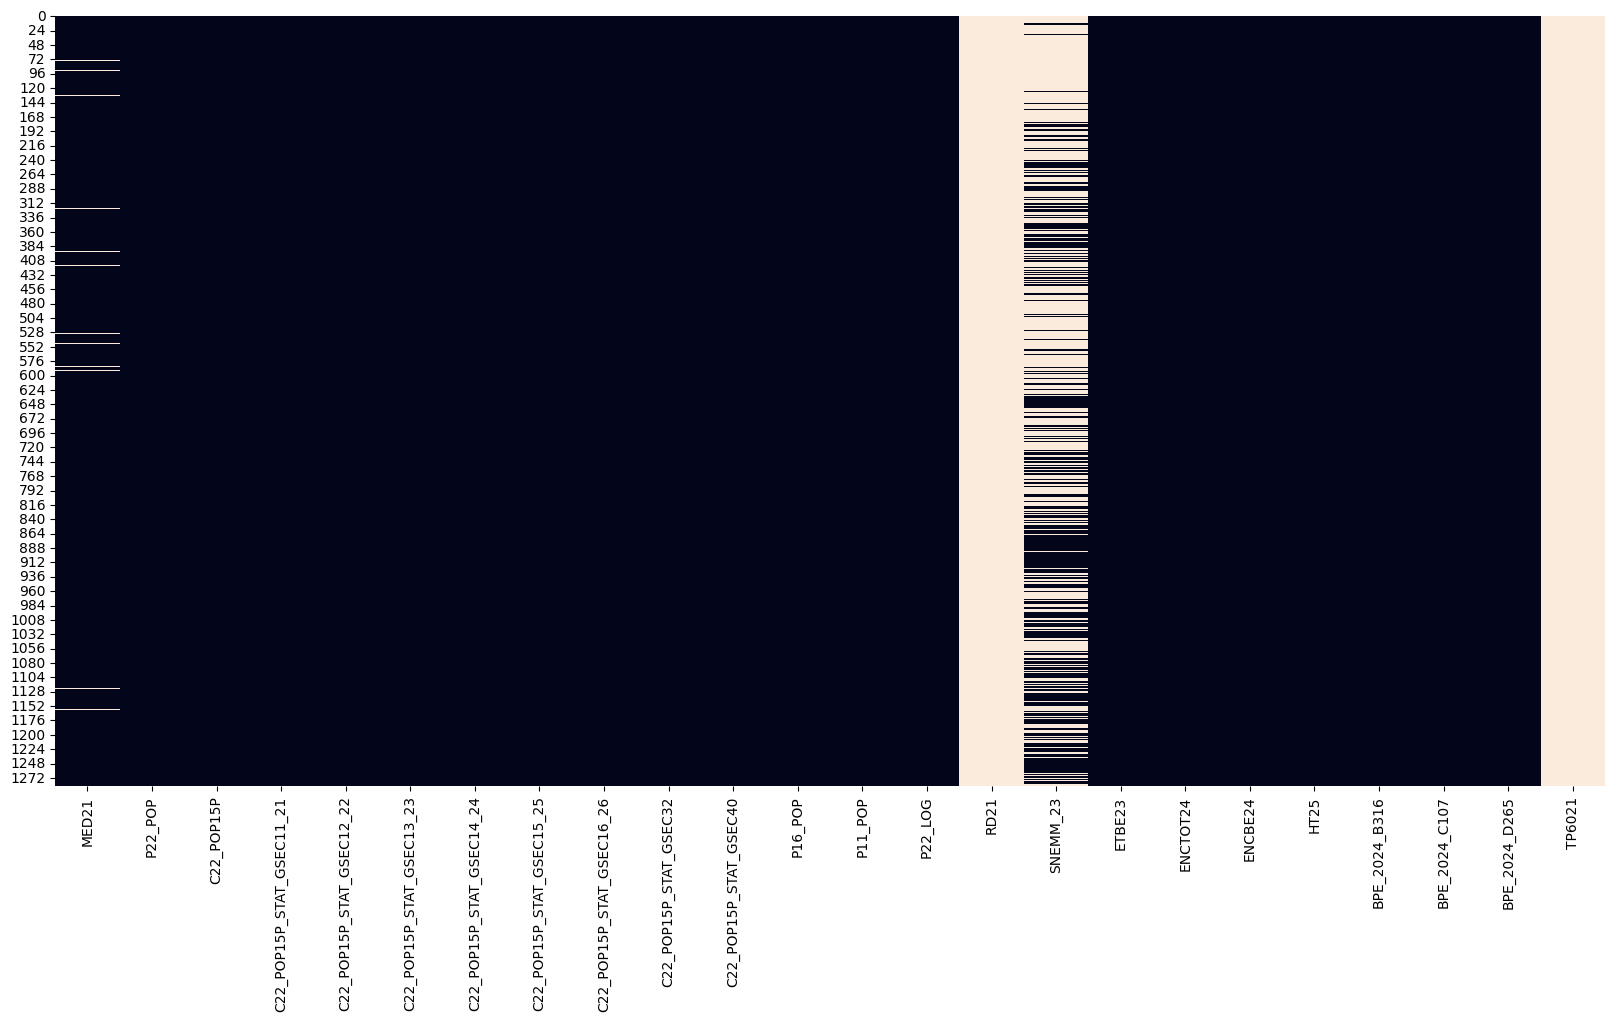

In [26]:
#### On cherche maintenant à trier dans nos variables d'intérêt : on regarde nos variables démographiques et on visualise les NAs

# On crée un df avec les variables démographiques d'intérêt
communes_idf_dem = communes_idf[["MED21", "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "RD21", "SNEMM_23", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265", "TP6021"]]

# On transforme les "s" (convention INSEE) en NAs (ce qu'ils signifient) - cela ne concerne que TP6021 et RD21 (les autres sont déjà des float)
communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
communes_idf_dem["MED21"] = pd.to_numeric(communes_idf_dem["MED21"], errors='coerce')

# On visualise les NAs
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_dem.isna(), cbar=False)

In [27]:
# On regarde les NAs
communes_idf_dem.isna().sum()

MED21                          15
P22_POP                         1
C22_POP15P                      1
C22_POP15P_STAT_GSEC11_21       1
C22_POP15P_STAT_GSEC12_22       1
C22_POP15P_STAT_GSEC13_23       1
C22_POP15P_STAT_GSEC14_24       1
C22_POP15P_STAT_GSEC15_25       1
C22_POP15P_STAT_GSEC16_26       1
C22_POP15P_STAT_GSEC32          1
C22_POP15P_STAT_GSEC40          1
P16_POP                         1
P11_POP                         1
P22_LOG                         1
RD21                         1286
SNEMM_23                      740
ETBE23                          1
ENCTOT24                        1
ENCBE24                         1
HT25                            1
BPE_2024_B316                   1
BPE_2024_C107                   1
BPE_2024_D265                   1
TP6021                       1286
dtype: int64

In [28]:
#### On réduit, à titre provisoire, notre df total à quelques variables d'intérêt (sans TP601, RD21 ni SNEMM_23 à cause des NAs)

# On sélectionne les variables
communes_idf_short = communes_idf.copy()
communes_idf_short = communes_idf_short[[
    
    # Variables descriptives
"insee", "nom", "departement", "densite", "surf_ha", "geometry", "centroid", "x", "y",

    # Variables démographiques (dossier complet de l'insee)
"MED21", "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265",
"part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers", "croissance_demographique_2011_2022",

    # Variables liées à la pollution industrielles tirées de Géorisques
"Polluee", "rejets_isoles", "nb_etablissements_isoles", "rejets_raccordes", "nb_etablissements_raccordes", "rejets_tot", "nb_etablissements_rejets_tot",
"nombre_etablissements_emissions", "nombre_etablissements_emissions_2_plus", "nombre_etablissements_emissions_3_plus", "nombre_etablissements_dechets",
"nombre_etablissements_dechets_2_plus", "nombre_etablissements_dechets_3_plus",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10"]]

In [29]:
# On renomme les colonnes 

communes_idf_short = communes_idf_short.rename(
    columns = {"MED21" : "revenu_median_2021",
    "P22_POP" : "population_2022",
    "C22_POP15P" : "population_15_plus",
    "C22_POP15P_STAT_GSEC11_21" : "nombre_agriculteurs",
    "C22_POP15P_STAT_GSEC12_22" : "nombre_artisans",
    "C22_POP15P_STAT_GSEC13_23" : "nombre_cpis",
    "C22_POP15P_STAT_GSEC14_24" : "nombre_pi",
    "C22_POP15P_STAT_GSEC15_25" : "nombre_employes",
    "C22_POP15P_STAT_GSEC16_26" : "nombre_ouvriers",
    "C22_POP15P_STAT_GSEC32" : "nombre_retraites",
    "C22_POP15P_STAT_GSEC40" : "nombre_sans_activite",
    "P16_POP" : "population_2016",
    "P11_POP" : "population_2011",
    "P22_LOG" : "nombre_logements",
    "ETBE23" : "nombre_etablissements_industrie",
    "ENCTOT24" : "creations_entreprises",
    "ENCBE24" : "creations_entreprises_industrie",
    "HT25" : "nombre_hôtels_2025",
    "BPE_2024_B316" : "nombre_stations_service",
    "BPE_2024_C107" : "nombre_ecoles_maternelles",
    "BPE_2024_D265" : "nombre_medecins_generalistes"
    }
)

In [30]:
# On crée des variables "par habitant"

communes_idf_short["logements_habitant"] = communes_idf_short["nombre_logements"] / communes_idf_short["population_2022"]
communes_idf_short["industries_habitant"] = communes_idf_short["nombre_etablissements_industrie"] / communes_idf_short["population_2022"]
communes_idf_short["stations_service_habitant"] = communes_idf_short["nombre_stations_service"] / communes_idf_short["population_2022"]
communes_idf_short["ecoles_maternelles_habitant"] = communes_idf_short["nombre_ecoles_maternelles"] / communes_idf_short["population_2022"]
communes_idf_short["medecins_generalistes_habitant"] = communes_idf_short["nombre_medecins_generalistes"] / communes_idf_short["population_2022"]
communes_idf_short["hotels_habitant"] = communes_idf_short["nombre_hôtels_2025"] / communes_idf_short["population_2022"]

In [31]:
## Nettoyage

# On convertit le revenu médian en numérique
communes_idf_short["revenu_median_2021"] = pd.to_numeric(communes_idf_short["revenu_median_2021"], errors = "coerce")

# On nettoie le revenu médian en supprimant les (15) lignes non renseignées
communes_idf_short = communes_idf_short.dropna(subset=['revenu_median_2021'])

# On supprime la ville de Pierrefitte (dont on a remarqué qu'elle est la seule pour laquelle P22_POP n'est pas renseignée)
communes_idf_short = communes_idf_short[communes_idf_short["insee"] != "93059"]

<Axes: >

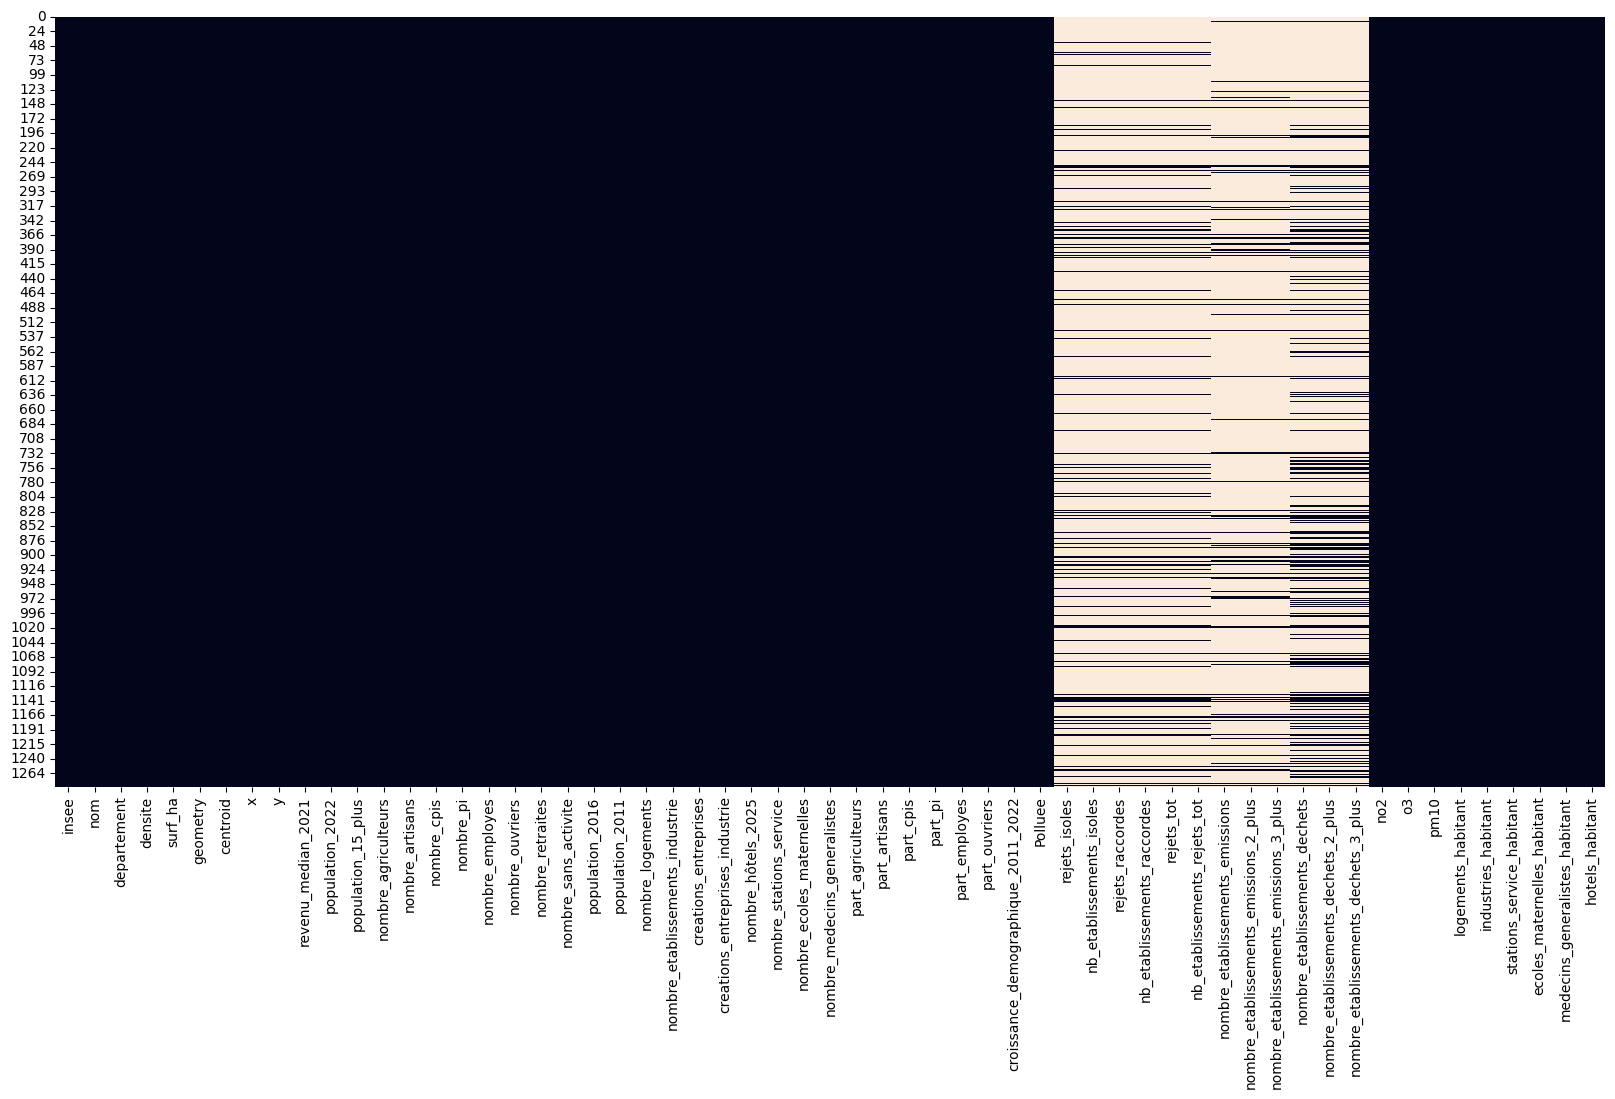

In [32]:
# On visualise les valeurs manquantes (aucune sauf pour les rejets - car NA = 0 ici)
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_short.isna(), cbar=False)

**Partie 3 : Visualisations et analyses exploratoires**

*3.1 Exploration de la cartographie des pollutions*

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

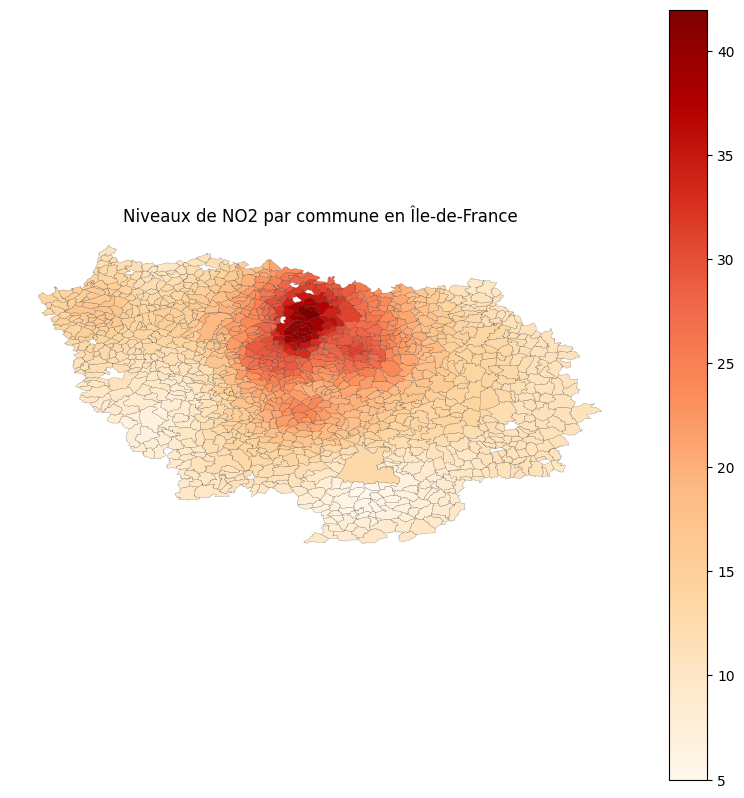

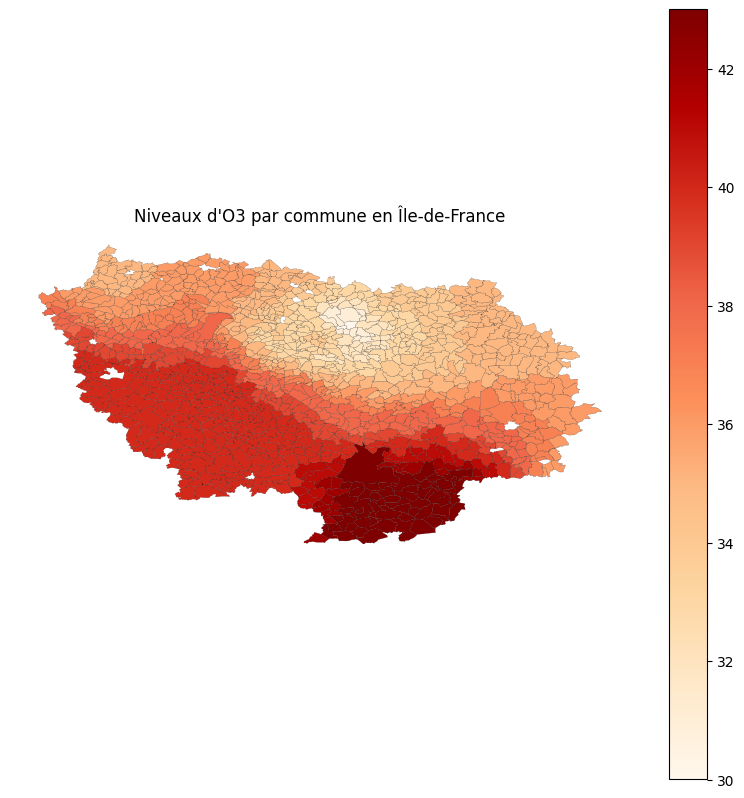

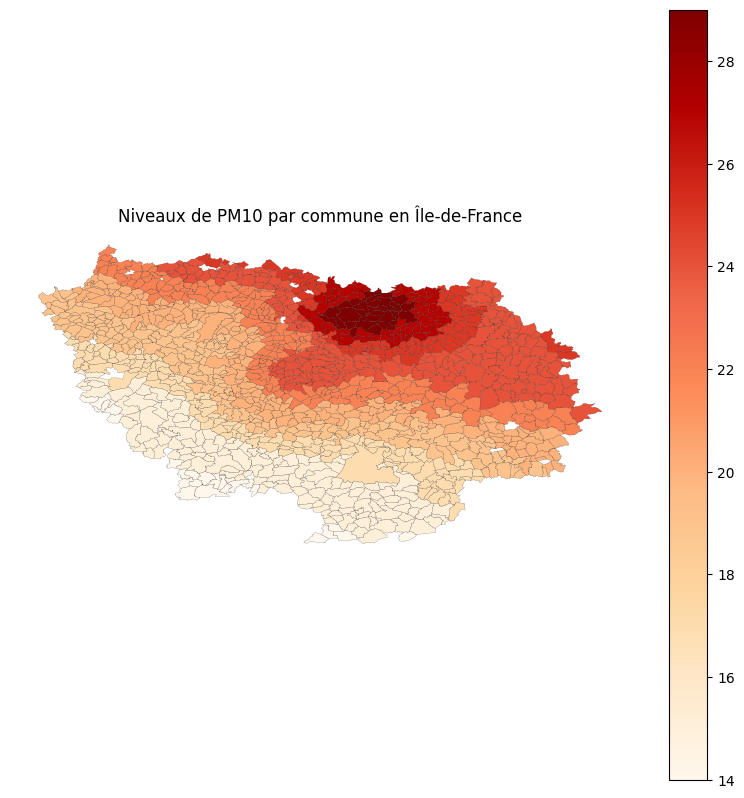

In [33]:
# NO2
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="no2",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux de NO2 par commune en Île-de-France")
ax.axis("off")

# 03
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="o3",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux d'O3 par commune en Île-de-France")
ax.axis("off")

# PM10
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="pm10",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Niveaux de PM10 par commune en Île-de-France")
ax.axis("off")

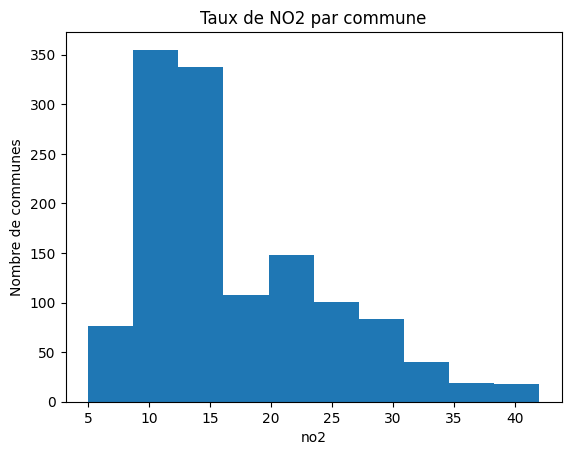

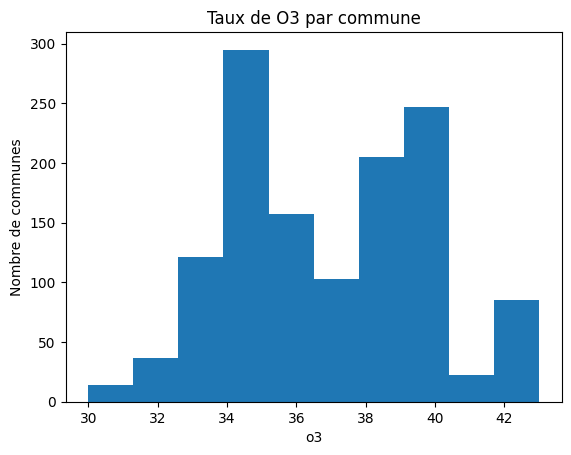

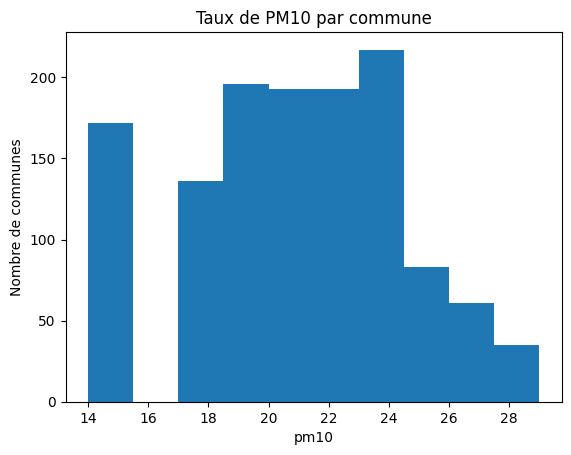

In [34]:
# NO2
plt.hist(communes_idf["no2"])
plt.xlabel("no2")
plt.ylabel("Nombre de communes")
plt.title("Taux de NO2 par commune")
plt.show()

# O3
plt.hist(communes_idf["o3"])
plt.xlabel("o3")
plt.ylabel("Nombre de communes")
plt.title("Taux de O3 par commune")
plt.show()

# PM10
plt.hist(communes_idf["pm10"])
plt.xlabel("pm10")
plt.ylabel("Nombre de communes")
plt.title("Taux de PM10 par commune")
plt.show()

<Axes: >

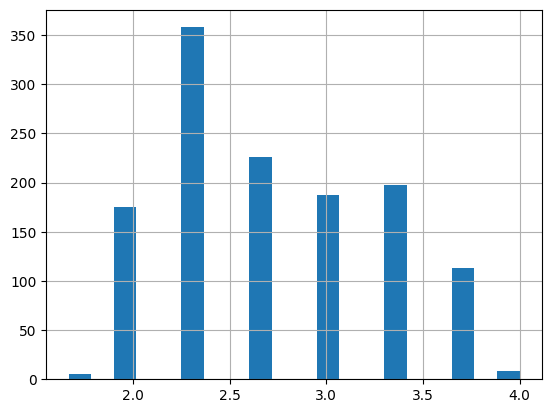

In [35]:
## On crée des tertiles

# PM10
communes_idf_short["quantile_pm10"] = pd.qcut(
    communes_idf_short["pm10"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# 03
communes_idf_short["quantile_o3"] = pd.qcut(
    communes_idf_short["o3"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# N02
communes_idf_short["quantile_no2"] = pd.qcut(
    communes_idf_short["no2"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# On convertit les catégories en numériques
communes_idf_short["quantile_pm10"] = pd.to_numeric(communes_idf_short["quantile_pm10"])
communes_idf_short["quantile_o3"] = pd.to_numeric(communes_idf_short["quantile_o3"])
communes_idf_short["quantile_no2"] = pd.to_numeric(communes_idf_short["quantile_no2"])

# On crée un score (moyenne)
communes_idf_short["pollution_air"] = (
    communes_idf_short[["quantile_pm10", "quantile_o3", "quantile_no2"]]
    .mean(axis=1)
)

# On observe sa distribution
communes_idf_short["pollution_air"].hist(bins=20)

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

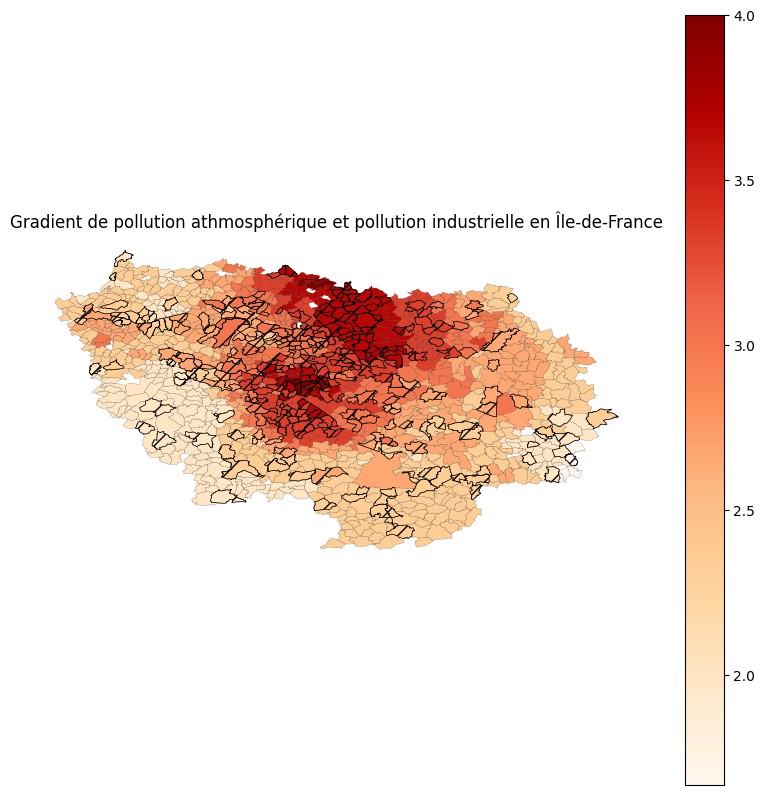

In [36]:
## Pollution air et pollution industrielle

fig, ax = plt.subplots(figsize=(10, 10))

communes_idf_short.plot(
    column="pollution_air",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

communes_idf_short[
    communes_idf_short["Polluee"]].plot(
    facecolor="none",
    hatch="/",
    linewidth=0.5,
    ax=ax
)

ax.set_title("Gradient de pollution athmosphérique et pollution industrielle en Île-de-France")
ax.axis("off")


(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

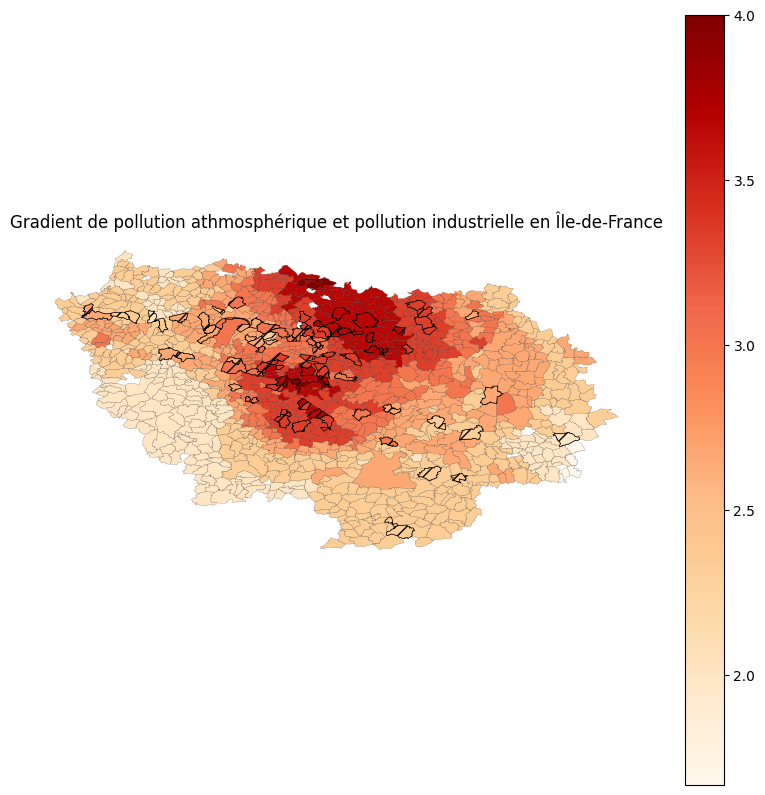

In [37]:
## Pollution air et pollution industrielle - plus fin

fig, ax = plt.subplots(figsize=(10, 10))

communes_idf_short.plot(
    column="pollution_air",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

communes_idf_short[
    communes_idf_short["nombre_etablissements_emissions_2_plus"] >= 1
].plot(
    facecolor="none",
    hatch="/",
    linewidth=0.5,
    ax=ax
)

ax.set_title("Gradient de pollution athmosphérique et pollution industrielle en Île-de-France")
ax.axis("off")


(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

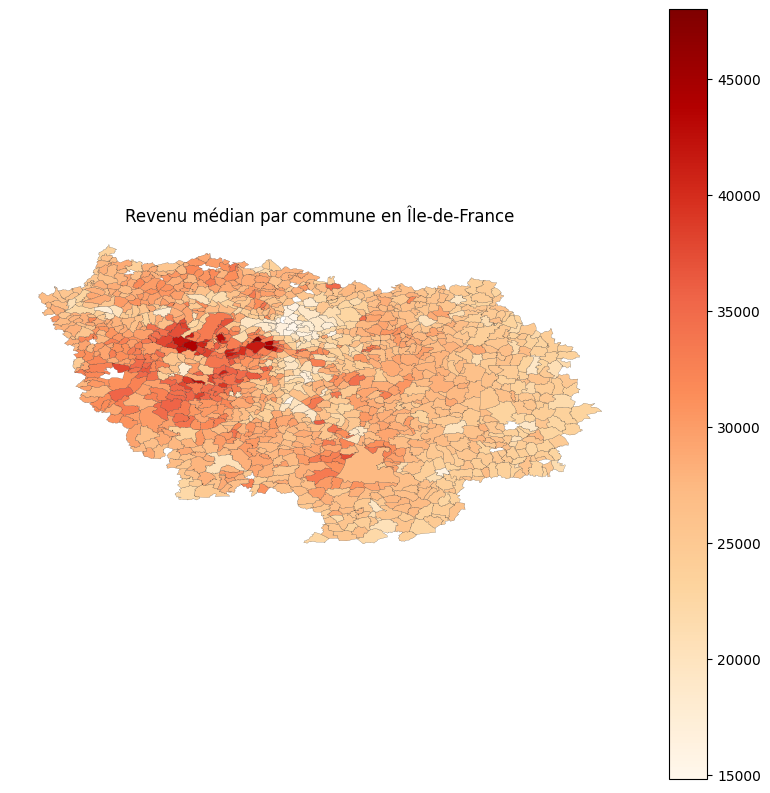

In [38]:
# Revenu médian

communes_idf_short["revenu_median_2021"] = communes_idf_short["revenu_median_2021"].astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="revenu_median_2021",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Revenu médian par commune en Île-de-France")
ax.axis("off")

In [39]:
# Ajouter une colonne pour distinguer "bas / haut"
communes_idf_short["groupe_revenu"] = None
communes_idf_short.loc[communes_idf_short["revenu_median_2021"] < communes_idf_short["revenu_median_2021"].quantile(0.10), "groupe_revenu"] = "Bas"
communes_idf_short.loc[communes_idf_short["revenu_median_2021"] >= communes_idf_short["revenu_median_2021"].quantile(0.90), "groupe_revenu"] = "Haut"

In [40]:
communes_idf_short["groupe_revenu"].value_counts()

groupe_revenu
Bas     127
Haut    127
Name: count, dtype: int64

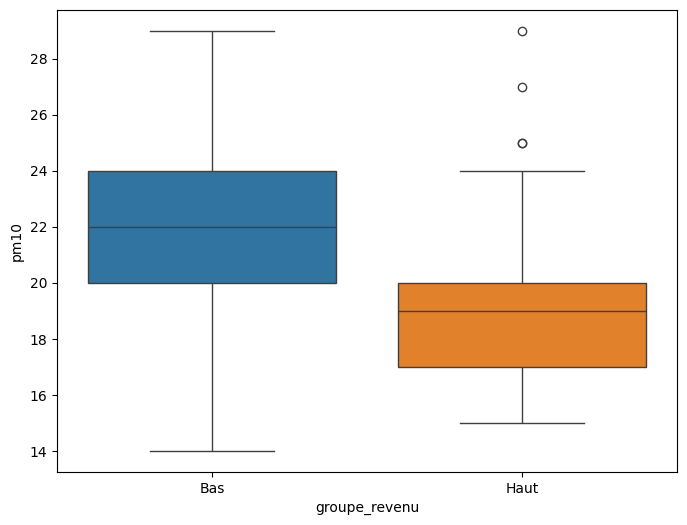

In [41]:
plt.figure(figsize=(8,6))
sns.boxplot(x="groupe_revenu", y="pm10", data=communes_idf_short,
            hue = "groupe_revenu",
            legend=False)
plt.show()

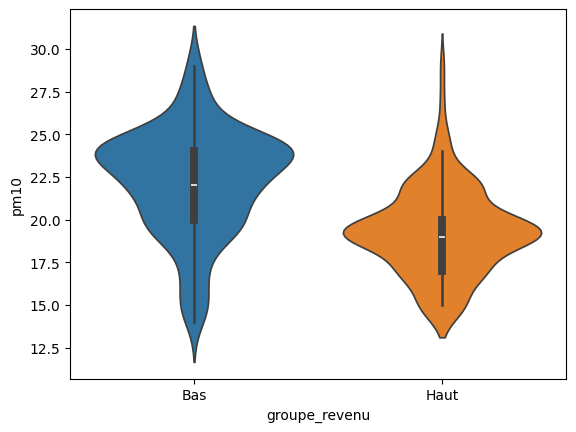

In [42]:
sns.violinplot(x="groupe_revenu", y="pm10", data=communes_idf_short,
            hue = "groupe_revenu",
            legend=False)
plt.show()

*3.2. Corrélations entre pollutions*

In [43]:
## On crée un df réduit aux colonnes de sources de pollution pour étudier si elles sont liées entre elles

communes_idf_pollutions = communes_idf_short[
    [
     # Variables liées à la pollution industrielles tirées de Géorisques
"Polluee", "rejets_isoles", "nb_etablissements_isoles", "rejets_raccordes", "nb_etablissements_raccordes", "rejets_tot", "nb_etablissements_rejets_tot",
"nombre_etablissements_emissions", "nombre_etablissements_emissions_2_plus", "nombre_etablissements_emissions_3_plus", "nombre_etablissements_dechets",
"nombre_etablissements_dechets_2_plus", "nombre_etablissements_dechets_3_plus",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10"]
].copy()

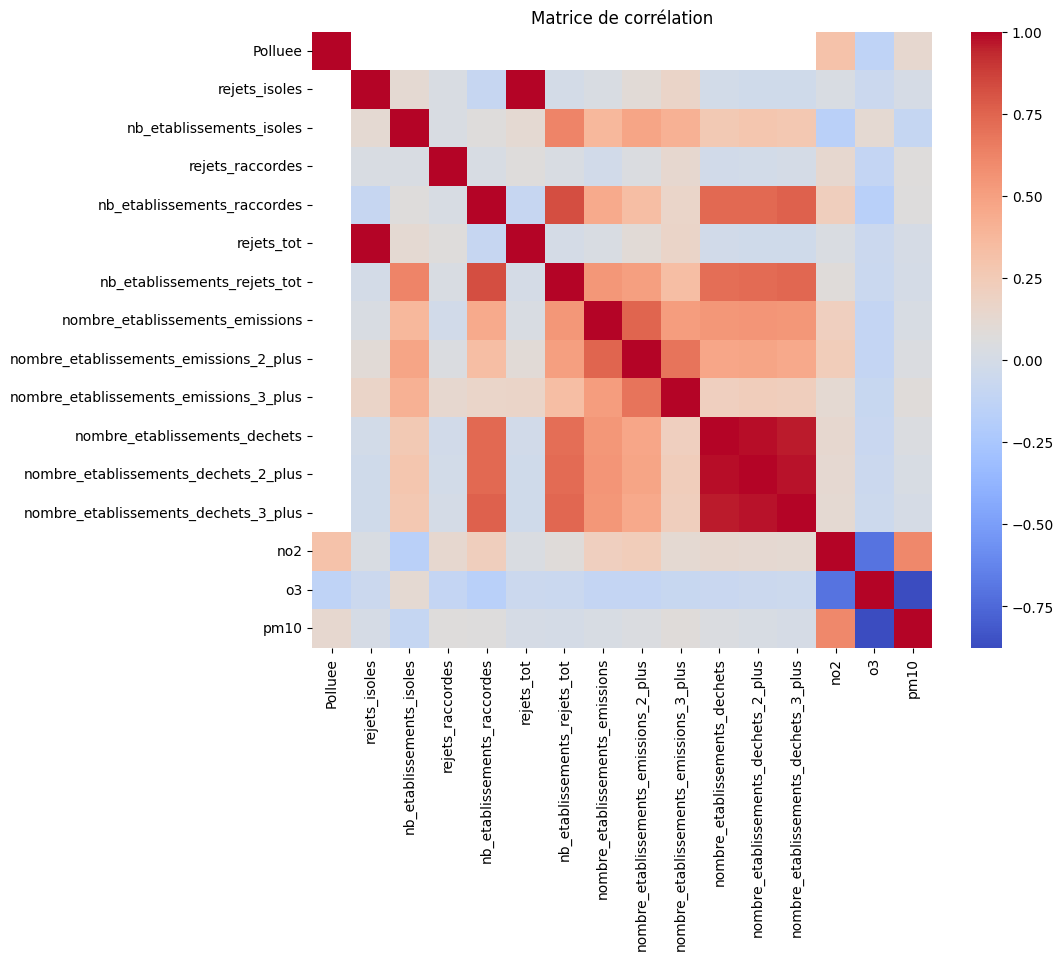

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(communes_idf_pollutions.corr(), cmap="coolwarm")  # pas de cbar=False
plt.title("Matrice de corrélation")
plt.show()


In [45]:
communes_idf_pollutions.corr()

,Polluee,rejets_isoles,nb_etablissements_isoles,rejets_raccordes,nb_etablissements_raccordes,rejets_tot,nb_etablissements_rejets_tot,nombre_etablissements_emissions,nombre_etablissements_emissions_2_plus,nombre_etablissements_emissions_3_plus,nombre_etablissements_dechets,nombre_etablissements_dechets_2_plus,nombre_etablissements_dechets_3_plus,no2,o3,pm10
Polluee,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.309282,-0.133906,0.134561
rejets_isoles,NaN,1.000000,0.116775,0.027001,-0.088041,0.999068,-0.004010,0.028681,0.091646,0.165385,-0.017778,-0.028908,-0.026478,0.030718,-0.056964,0.006516
nb_etablissements_isoles,NaN,0.116775,1.000000,0.029317,0.076000,0.117796,0.619230,0.370842,0.475777,0.412781,0.267022,0.286083,0.267951,-0.163718,0.115414,-0.094599
rejets_raccordes,NaN,0.027001,0.029317,1.000000,0.018227,0.070123,0.030753,-0.022379,0.046569,0.128466,-0.021681,-0.016097,-0.003274,0.131597,-0.103877,0.070875
nb_etablissements_raccordes,NaN,-0.088041,0.076000,0.018227,1.000000,-0.087070,0.830000,0.449626,0.339673,0.160057,0.729795,0.730792,0.765143,0.220268,-0.166629,0.063674
rejets_tot,NaN,0.999068,0.117796,0.070123,-0.087070,1.000000,-0.002673,0.027684,0.093559,0.170757,-0.019640,-0.030087,-0.026452,0.036336,-0.061330,0.009563
nb_etablissements_rejets_tot,NaN,-0.004010,0.619230,0.030753,0.830000,-0.002673,1.000000,0.538924,0.508844,0.337828,0.713289,0.724680,0.741148,0.081878,-0.066657,-0.002774
nombre_etablissements_emissions,NaN,0.028681,0.370842,-0.022379,0.449626,0.027684,0.538924,1.000000,0.750703,0.511113,0.540222,0.546537,0.544504,0.213975,-0.106131,0.023761
nombre_etablissements_emissions_2_plus,NaN,0.091646,0.475777,0.046569,0.339673,0.093559,0.508844,0.750703,1.000000,0.687679,0.469824,0.474278,0.454926,0.236713,-0.101617,0.043602
nombre_etablissements_emissions_3_plus,NaN,0.165385,0.412781,0.128466,0.160057,0.170757,0.337828,0.511113,0.687679,1.000000,0.215749,0.225130,0.222344,0.114722,-0.082918,0.077656


In [46]:
## On crée un df encore plus réduit pour observer le rapport entre des pollutions a priori indépendantes

communes_idf_pollutions2 = communes_idf_short[
    [
     # Variables liées à la pollution industrielles tirées de Géorisques
"nb_etablissements_rejets_tot", "nombre_etablissements_emissions", "nombre_etablissements_dechets",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10"]
].copy()

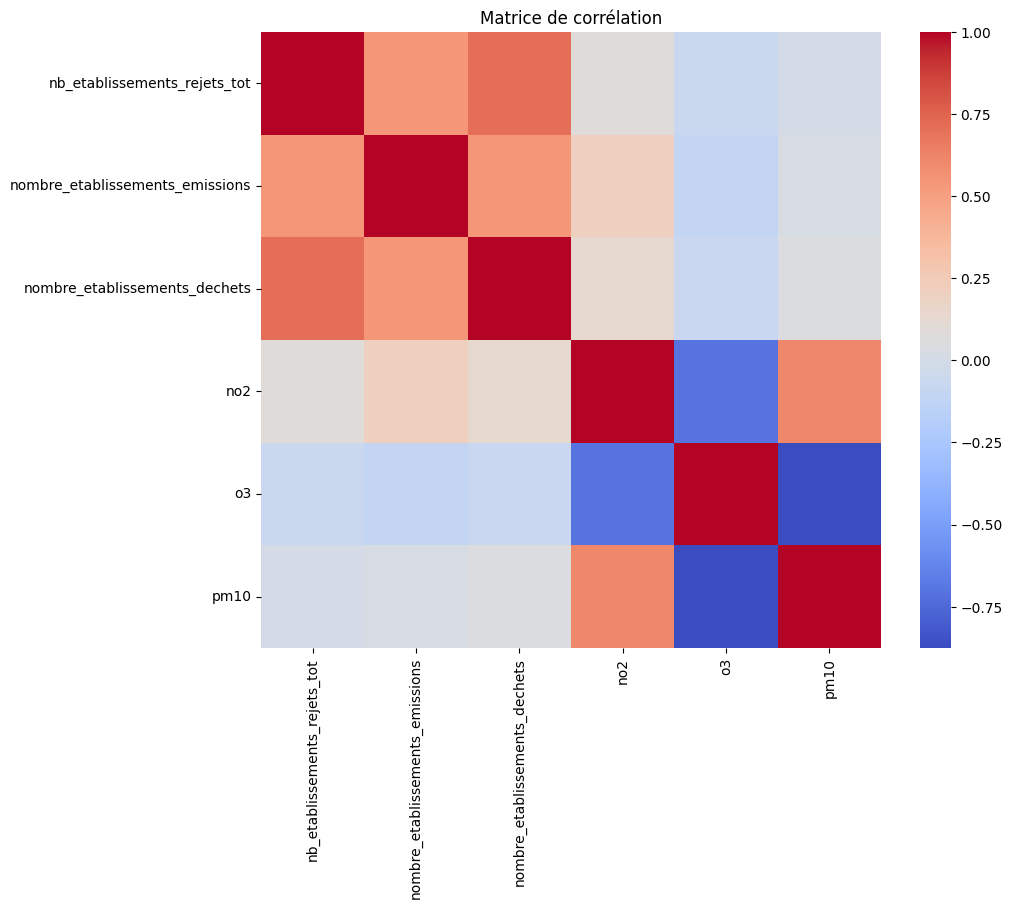

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(communes_idf_pollutions2.corr(), cmap="coolwarm")  # pas de cbar=False
plt.title("Matrice de corrélation")
plt.show()

En conclusion, les pollutions de l'air sont très liées entre elles (no2 et pm10 au mêmes endroits, o3 à l'opposé), et de même des pollutions industrielles.
Le lien entre ces deux types de lien est par contre bien moins apparent par une mesure de corrélation linéaire : seul le lien entre no2 et émissions par des établissements industriels est manifestement intéressant ici. 

Cependant, la relative indépendance linéaire des pollutions industrielle et atmosphérique peut également être un atout du point de vue de notre analyse. En effet, les zones exposées aux deux sont plus rares, et il devient d'autant plus intéressant d'étudier les caractéristiques des communes qui "cumulent" les expositions aux deux types de pollution. C'est, entre autres choses, ce que nous faisons dans la sous-partie suivante, consacrée au lien entre exposition à la pollution et caractéristiques sociodémographiques.

*3.3. Corrélation entre pollution et démographie*

In [48]:
## On crée un df réduit qui rassemble les métriques choisies pour la pollution et quelques indicateurs sociodémographiques

communes_idf_pollutions_dem = communes_idf_short[
    [
     # Variables liées à la pollution industrielles tirées de Géorisques
"nb_etablissements_rejets_tot", "nombre_etablissements_emissions", "nombre_etablissements_dechets",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10",

    # Variables démographiques
"revenu_median_2021", "population_2022", "part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers",
"croissance_demographique_2011_2022", "industries_habitant", "stations_service_habitant", "ecoles_maternelles_habitant",
"medecins_generalistes_habitant"
]
].copy()

In [49]:
communes_idf_pollutions_dem.corr()

,nb_etablissements_rejets_tot,nombre_etablissements_emissions,nombre_etablissements_dechets,no2,o3,pm10,revenu_median_2021,population_2022,part_agriculteurs,part_artisans,part_cpis,part_pi,part_employes,part_ouvriers,croissance_demographique_2011_2022,industries_habitant,stations_service_habitant,ecoles_maternelles_habitant,medecins_generalistes_habitant
nb_etablissements_rejets_tot,1.000000,0.538924,0.713289,0.081878,-0.066657,-0.002774,-0.230668,0.300054,-0.120393,-0.062531,-0.050042,-0.210203,0.059920,0.098317,0.066737,-0.033928,-0.082922,0.038067,0.031553
nombre_etablissements_emissions,0.538924,1.000000,0.540222,0.213975,-0.106131,0.023761,-0.231081,0.281304,-0.104603,-0.071679,-0.051372,-0.188843,0.042058,0.148437,0.012614,0.033835,-0.077768,0.117372,-0.032110
nombre_etablissements_dechets,0.713289,0.540222,1.000000,0.128451,-0.075186,0.042952,-0.289889,0.185459,-0.115273,-0.151327,-0.122486,-0.205371,0.118371,0.183948,0.059727,0.068807,-0.021265,0.039916,0.017512
no2,0.081878,0.213975,0.128451,1.000000,-0.703927,0.609622,-0.148141,0.518187,-0.240077,-0.229966,0.170392,-0.054097,0.107587,-0.076570,0.200062,0.080647,-0.004748,-0.039381,0.139525
o3,-0.066657,-0.106131,-0.075186,-0.703927,1.000000,-0.875727,0.157385,-0.270274,0.089150,0.156971,-0.011220,-0.034962,-0.194716,-0.067818,-0.161287,-0.043371,0.044845,0.044433,-0.076268
pm10,-0.002774,0.023761,0.042952,0.609622,-0.875727,1.000000,-0.224741,0.144498,-0.064406,-0.181851,-0.130439,0.059007,0.266895,0.172697,0.206402,0.039175,-0.003774,-0.037591,0.055093
revenu_median_2021,-0.230668,-0.231081,-0.289889,-0.148141,0.157385,-0.224741,1.000000,-0.131827,-0.043367,0.238962,0.725085,0.044619,-0.577533,-0.620511,-0.143656,0.022776,-0.017320,-0.038462,0.034073
population_2022,0.300054,0.281304,0.185459,0.518187,-0.270274,0.144498,-0.131827,1.000000,-0.167638,-0.191948,0.292129,-0.220664,0.000166,-0.114395,-0.023148,-0.034587,-0.036783,0.000264,0.114674
part_agriculteurs,-0.120393,-0.104603,-0.115273,-0.240077,0.089150,-0.064406,-0.043367,-0.167638,1.000000,0.085582,-0.201886,-0.050043,0.006331,0.188347,-0.117264,-0.008869,-0.032644,-0.006351,-0.080958
part_artisans,-0.062531,-0.071679,-0.151327,-0.229966,0.156971,-0.181851,0.238962,-0.191948,0.085582,1.000000,0.021014,-0.063505,-0.220801,-0.154828,-0.089156,-0.003306,0.023060,-0.026738,-0.034323


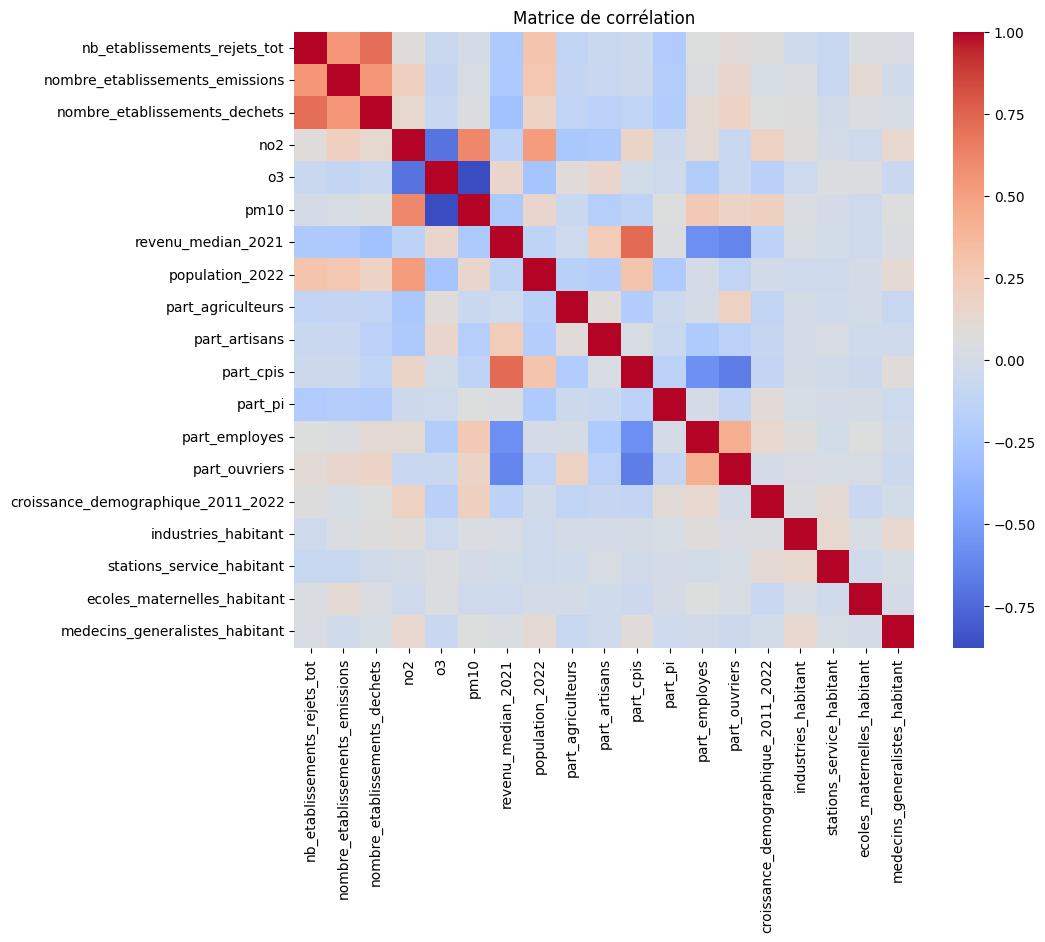

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(communes_idf_pollutions_dem.corr(), cmap="coolwarm")  
plt.title("Matrice de corrélation")
plt.show()

In [51]:
## On crée la distance à Paris

# Coordonnées de Paris 5e
x_Paris_5 = communes_idf_short.loc[communes_idf_short["insee"] == "75105", "x"].iloc[0]
y_Paris_5 = communes_idf_short.loc[communes_idf_short["insee"] == "75105", "y"].iloc[0]

# Distance euclidienne de chaque commune au 5e
communes_idf_short["distance_a_Paris"] = np.sqrt(
    (communes_idf_short["x"] - x_Paris_5)**2 +
    (communes_idf_short["y"] - y_Paris_5)**2
)

# On prend également en compte l'angle
communes_idf_short["angle_paris"] = np.arctan2(
    communes_idf_short["y"] - y_Paris_5,
    communes_idf_short["x"] - x_Paris_5
)

# On prend le cosinus et le sinus de l'angle pour identifier le nord-est, le sud-ouest...
communes_idf_short["cos_angle"] = np.cos(communes_idf_short["angle_paris"])
communes_idf_short["sin_angle"] = np.sin(communes_idf_short["angle_paris"])

**Partie 5 : Modélisation**

5.1. Régression de la qualité de l'air (pm10, o3, no2) sur des variables démographiques et spatiales

In [52]:
## On régresse PM10 sur plein de variables

# Variable dépendante
y_pm10 = communes_idf_short['pm10']

# Variables explicatives
X_dem = communes_idf_short[["surf_ha", "revenu_median_2021", "densite", "Polluee", "croissance_demographique_2011_2022",
"part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers", "stations_service_habitant",
"ecoles_maternelles_habitant", "medecins_generalistes_habitant", "hotels_habitant", "industries_habitant", "creations_entreprises"
]]

# Standardiser les colonnes continues
scaler = StandardScaler()
cols_scale = ["surf_ha", "revenu_median_2021", "densite", "croissance_demographique_2011_2022",
"part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers", "industries_habitant", "stations_service_habitant",
"ecoles_maternelles_habitant", "medecins_generalistes_habitant", "hotels_habitant", "creations_entreprises"]

X_dem_scaled = pd.DataFrame(scaler.fit_transform(X_dem[cols_scale]),

                        columns=cols_scale,

                        index=X_dem.index)

# On ajoute la variable binaire sans standardisation
X_dem_scaled['Polluee'] = X_dem['Polluee'].astype(int)

# On ajoute l'intercept
X_dem_const = sm.add_constant(X_dem_scaled)

# Construction et ajustement du modèle
model_pm10_dem_std = sm.OLS(y_pm10, X_dem_const).fit()

# Résumé complet
print(model_pm10_dem_std.summary())

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     16.36
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           6.24e-44
Time:                        09:19:47   Log-Likelihood:                -3331.5
No. Observations:                1270   AIC:                             6699.
Df Residuals:                    1252   BIC:                             6792.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [53]:
# On affiche les VIF (VIF > 5 : variable très corrélées aux autres variables du modèle)

vif_data = pd.DataFrame()
vif_data["feature"] = X_dem_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_dem_scaled.values, i) for i in range(X_dem_scaled.shape[1])]
print(vif_data)

                               feature       VIF
0                              surf_ha  1.121379
1                   revenu_median_2021  3.736434
2                              densite  2.503426
3   croissance_demographique_2011_2022  1.121752
4                    part_agriculteurs  1.137560
5                        part_artisans  1.231694
6                            part_cpis  5.039773
7                              part_pi  1.203170
8                        part_employes  1.766693
9                        part_ouvriers  2.129075
10                 industries_habitant  1.130655
11           stations_service_habitant  1.040608
12         ecoles_maternelles_habitant  1.014629
13      medecins_generalistes_habitant  1.050664
14                     hotels_habitant  1.124206
15               creations_entreprises  1.807681
16                             Polluee  1.221412


In [54]:
## On écrit une fonction pour supprimer, de façon itérative, les variables avec un fort VIF (chatGPT : reprendre)

def reduce_vif(X, threshold=5):
    X = X.copy()
    
    while True:
        vif = pd.DataFrame({
            "feature": X.columns,
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })
        
        max_vif = vif["VIF"].max()
        
        if max_vif <= threshold:
            break
        
        feature_to_drop = vif.loc[vif["VIF"].idxmax(), "feature"]
        print(f"Suppression de {feature_to_drop} (VIF = {max_vif:.2f})")
        
        X = X.drop(columns=[feature_to_drop])
    
    return X

In [55]:
# On applique la fonction : on supprime une par une les variables à fort VIF (ie très corrélées entre elles)
X_for_vif = X_dem_scaled.drop(columns=['Polluee'])
X_dem_reduced = reduce_vif(X_for_vif, threshold=5)
X_dem_reduced['Polluee'] = X_dem_scaled['Polluee']

Suppression de part_cpis (VIF = 5.01)


In [56]:
## On refait la régression avec moins de régresseurs

# On ajoute l'intercept
X_dem_reduced_const = sm.add_constant(X_dem_reduced)

# Construction et ajustement du modèle
model_pm10_dem_std_reduced = sm.OLS(y_pm10, X_dem_reduced_const).fit()

# Résumé complet
print(model_pm10_dem_std_reduced.summary())      

### REMARQUE : on a diminué les AIC et BIC mais le R^2 est toujours faible. On va faire mieux avec l'O3 et surtout le NO2.

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     17.39
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           1.48e-44
Time:                        09:19:47   Log-Likelihood:                -3331.5
No. Observations:                1270   AIC:                             6697.
Df Residuals:                    1253   BIC:                             6784.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [57]:
#### Régression du o3 sur les variables "non spatiales"

# Variable dépendante
y_o3 = communes_idf_short['o3']

# Construction et ajustement du modèle
model_o3_dem_std = sm.OLS(y_o3, X_dem_const).fit()

# Résumé complet
print(model_o3_dem_std.summary())

### REMARQUE : le R^2 est légèrement meilleur (0.164) mais pareil pour les variables (à part densité, revenu médian et surface un peu)

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     22.22
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           2.55e-60
Time:                        09:19:47   Log-Likelihood:                -3007.7
No. Observations:                1270   AIC:                             6051.
Df Residuals:                    1252   BIC:                             6144.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [58]:
## Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_o3_dem_std_reduced = sm.OLS(y_o3, X_dem_reduced_const).fit()

# Résumé complet
print(model_o3_dem_std_reduced.summary())      

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     23.53
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           9.18e-61
Time:                        09:19:47   Log-Likelihood:                -3008.3
No. Observations:                1270   AIC:                             6051.
Df Residuals:                    1253   BIC:                             6138.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [59]:
#### Régression du no2 sur les variables "non spatiales"

# Variable dépendante
y_no2 = communes_idf_short['no2']

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 est nettement meilleur (0.457) et quelques variables ont un rôle notable (densité, polluee, popuation, revenu médian)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     61.12
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          9.96e-151
Time:                        09:19:47   Log-Likelihood:                -3968.7
No. Observations:                1270   AIC:                             7973.
Df Residuals:                    1252   BIC:                             8066.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [60]:
#### Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_reduced_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 baisse un peu (0.424)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     64.96
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          1.39e-151
Time:                        09:19:47   Log-Likelihood:                -3968.9
No. Observations:                1270   AIC:                             7972.
Df Residuals:                    1253   BIC:                             8059.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [61]:
#### On réduit de pas à pas le vecteur explicatif en supprimant les variables non significatives (pour diminuer les AIC et BIC)

In [62]:
# On supprime ecoles_maternelles_habitant
X_dem_reduced_const2 = X_dem_reduced_const.drop(columns=['ecoles_maternelles_habitant'])  
model_no2_dem_std2 = sm.OLS(y_no2, X_dem_reduced_const2).fit()
print(model_no2_dem_std2.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     69.11
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          4.32e-152
Time:                        09:19:47   Log-Likelihood:                -3969.9
No. Observations:                1270   AIC:                             7972.
Df Residuals:                    1254   BIC:                             8054.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [63]:
# On supprime part_pi
X_dem_reduced_const3 = X_dem_reduced_const2.drop(columns=['part_pi'])  
model_no2_dem_std3 = sm.OLS(y_no2, X_dem_reduced_const3).fit()
print(model_no2_dem_std3.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     73.99
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          7.52e-153
Time:                        09:19:47   Log-Likelihood:                -3970.3
No. Observations:                1270   AIC:                             7971.
Df Residuals:                    1255   BIC:                             8048.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [64]:
# On supprime revenu_median_2021
X_dem_reduced_const4 = X_dem_reduced_const3.drop(columns=['revenu_median_2021'])  
model_no2_dem_std4 = sm.OLS(y_no2, X_dem_reduced_const4).fit()
print(model_no2_dem_std4.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     78.56
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          5.41e-152
Time:                        09:19:47   Log-Likelihood:                -3974.6
No. Observations:                1270   AIC:                             7977.
Df Residuals:                    1256   BIC:                             8049.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [65]:
# On supprime part_ouvriers
X_dem_reduced_const5 = X_dem_reduced_const4.drop(columns=['part_ouvriers'])  
model_no2_dem_std5 = sm.OLS(y_no2, X_dem_reduced_const5).fit()
print(model_no2_dem_std5.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     85.18
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          5.74e-153
Time:                        09:19:47   Log-Likelihood:                -3974.6
No. Observations:                1270   AIC:                             7975.
Df Residuals:                    1257   BIC:                             8042.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [66]:
# On supprime stations_services_habitant
X_dem_reduced_const6 = X_dem_reduced_const5.drop(columns=['stations_service_habitant'])  
model_no2_dem_std6 = sm.OLS(y_no2, X_dem_reduced_const6).fit()
print(model_no2_dem_std6.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     92.98
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          6.14e-154
Time:                        09:19:47   Log-Likelihood:                -3974.6
No. Observations:                1270   AIC:                             7973.
Df Residuals:                    1258   BIC:                             8035.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [67]:
# On supprime medecins_generalistes_habitant
X_dem_reduced_const7 = X_dem_reduced_const6.drop(columns=['medecins_generalistes_habitant'])  
model_no2_dem_std7 = sm.OLS(y_no2, X_dem_reduced_const7).fit()
print(model_no2_dem_std7.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     100.9
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          3.34e-153
Time:                        09:19:47   Log-Likelihood:                -3978.7
No. Observations:                1270   AIC:                             7979.
Df Residuals:                    1259   BIC:                             8036.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [68]:
# On supprime creations_entreprises
X_dem_reduced_const8 = X_dem_reduced_const7.drop(columns=['creations_entreprises'])  
model_no2_dem_std8 = sm.OLS(y_no2, X_dem_reduced_const8).fit()
print(model_no2_dem_std8.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     111.4
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          2.02e-153
Time:                        09:19:47   Log-Likelihood:                -3980.6
No. Observations:                1270   AIC:                             7981.
Df Residuals:                    1260   BIC:                             8033.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [69]:
### On ajoute à la régression les coordonnées géographiques pour voir si cela annule tout le reste

# On crée le df démographique et spatial
X_dem_spatial = X_dem_reduced_const5
X_dem_spatial[["x", "y"]] = communes_idf_short[["x", "y"]]

# on standardise
scaler = StandardScaler()
X_dem_spatial[["x", "y"]] = scaler.fit_transform(X_dem_spatial[["x", "y"]])

# On construit le modèle
model_no2_dem_spatial = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial.summary())

### REMARQUE : au total, x et y augmentent nettement le R^2 mais n'écrasent pas le reste.

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     114.7
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          6.88e-213
Time:                        09:19:47   Log-Likelihood:                -3829.1
No. Observations:                1270   AIC:                             7688.
Df Residuals:                    1255   BIC:                             7765.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [70]:
### On ajoute l'effet croisé surface*densité

# Nouvelle variable
X_dem_spatial['densite_surf'] = X_dem_spatial['densite'] * X_dem_spatial['surf_ha']

# On construit le modèle
model_no2_dem_spatial2 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial2.summary())

### REMARQUE : l'effet croisé semble fort et augmente un peu le R^2 (grandes villes et denses = les plus polluées)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     109.4
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          3.73e-215
Time:                        09:19:47   Log-Likelihood:                -3821.3
No. Observations:                1270   AIC:                             7675.
Df Residuals:                    1254   BIC:                             7757.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

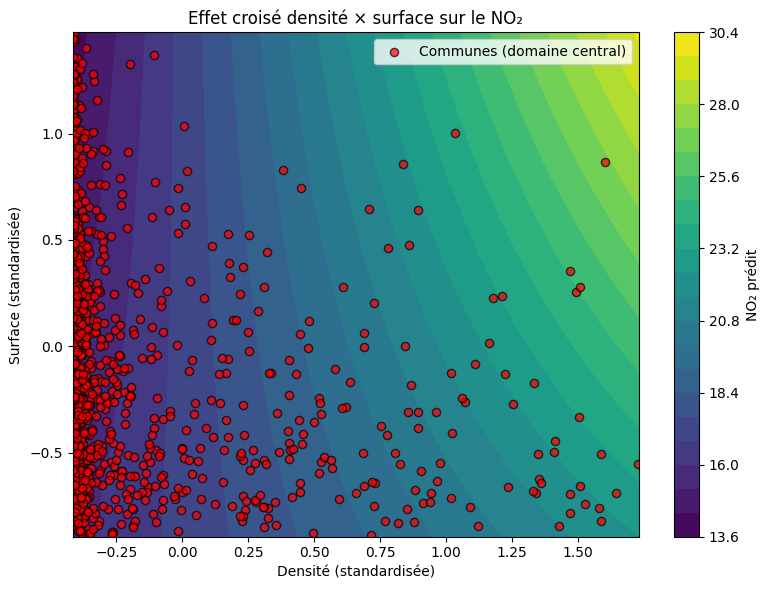

In [71]:
q_low, q_high = 0.05, 0.95

x = X_dem_spatial["densite"]
y = X_dem_spatial["surf_ha"]

x_min, x_max = x.quantile(q_low), x.quantile(q_high)
y_min, y_max = y.quantile(q_low), y.quantile(q_high)

x_vals = np.linspace(x_min, x_max, 60)
y_vals = np.linspace(y_min, y_max, 60)
X, Y = np.meshgrid(x_vals, y_vals)

coef = model_no2_dem_spatial2.params

Z = (
    coef["const"]
    + coef["densite"] * X
    + coef["surf_ha"] * Y
    + coef["densite_surf"] * X * Y
)


mask = (
    x.between(x_min, x_max)
    & y.between(y_min, y_max)
)

x_plot = x[mask]
y_plot = y[mask]


plt.figure(figsize=(8, 6))

cp = plt.contourf(X, Y, Z, levels=25, cmap="viridis")
plt.colorbar(cp, label="NO₂ prédit")

plt.scatter(
    x_plot, y_plot,
    c="red",
    edgecolor="black",
    s=35,
    alpha=0.7,
    label="Communes (domaine central)"
)

plt.xlabel("Densité (standardisée)")
plt.ylabel("Surface (standardisée)")
plt.title("Effet croisé densité × surface sur le NO₂")

plt.legend()
plt.tight_layout()
plt.show()


In [72]:
### On ajoute l'effet croisé x*y

# Nouvelle variable
X_dem_spatial['x_y'] = X_dem_spatial['x'] * X_dem_spatial['y']

# On construit le modèle
model_no2_dem_spatial3 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial3.summary())

### REMARQUE : l'effet croisé est significatif et augmente encore un peu le R^2 : être au nord-est est plus fort qu'être au nord et à l'est

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     110.4
Date:                Tue, 23 Dec 2025   Prob (F-statistic):          8.59e-226
Time:                        09:19:48   Log-Likelihood:                -3793.9
No. Observations:                1270   AIC:                             7622.
Df Residuals:                    1253   BIC:                             7709.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [73]:
### On ajoute, à la place des coordonnées géographiques "brutes", la distance à Paris et l'angle de la distance

# On crée le df démographique et spatial
X_dem_spatial[["distance_a_Paris", "cos_angle", "sin_angle"]] = communes_idf_short[["distance_a_Paris", "cos_angle", "sin_angle"]]

# on standardise
scaler = StandardScaler()
X_dem_spatial[["distance_a_Paris", "cos_angle", "sin_angle"]] = scaler.fit_transform(X_dem_spatial[["distance_a_Paris", "cos_angle", "sin_angle"]])

# On enlève x, y et x_y
X_dem_spatial = X_dem_spatial.drop(columns={"x", "y", "x_y"})

# On construit le modèle
model_no2_dem_spatial4 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial4.summary())

### La distance à Paris et l'angle de la distance augmente de 0.25 le R^2 !!!!!!!

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     351.0
Date:                Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:19:48   Log-Likelihood:                -3272.0
No. Observations:                1270   AIC:                             6578.
Df Residuals:                    1253   BIC:                             6666.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

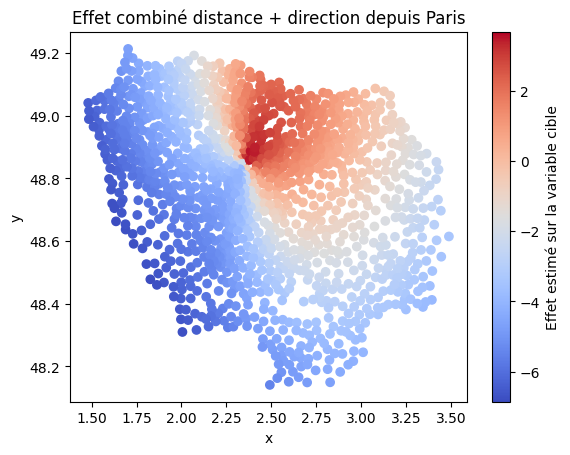

In [74]:
plt.scatter(communes_idf_short["x"], communes_idf_short["y"],
            c=(-4.7975*communes_idf_short["distance_a_Paris"]
               + 2.7575*communes_idf_short["cos_angle"]
               + 2.6125*communes_idf_short["sin_angle"]),
            cmap="coolwarm")
plt.colorbar(label="Effet estimé sur la variable cible")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Effet combiné distance + direction depuis Paris")
plt.show()


On va désormais analyser les résidus du modèle de la régression OLS. Cela nous permettra de détecter d'éventuels effets spatiaux non pris en compte par le modèle. En effet, les résidus correspondent à la différence entre les concentrations de NO2 observées et les valeurs prédites par le modèle à partir des variables explicatives. Ils capturent donc la part de la pollution non expliquée par les variables socio-démographiques que nous avons sélectionnées dans la régression.

In [ ]:
from sklearn.linear_model import LinearRegression

residuals = model_no2_dem_spatial4.resid
fitted = model_no2_dem_spatial4.fittedvalues

# Régression OLS des résidus sur les valeurs ajustées
reg_resid = LinearRegression()
reg_resid.fit(fitted.values.reshape(-1, 1), residuals.values)

resid_pred = reg_resid.predict(fitted.values.reshape(-1, 1))


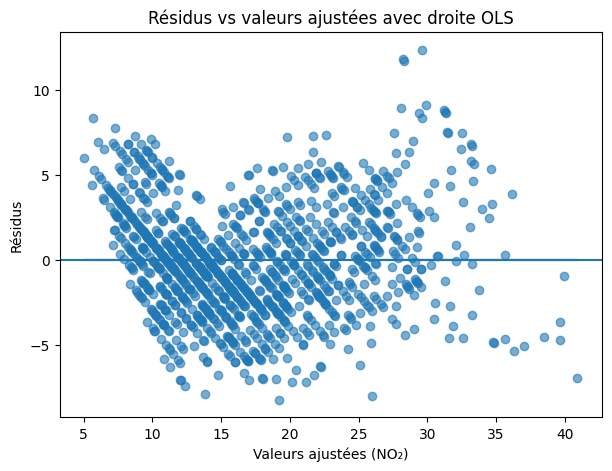

In [ ]:
# Graphique qui affiche les résidus du modèle
plt.figure(figsize=(7,5))

plt.scatter(fitted, residuals, alpha=0.6)
plt.plot(fitted, resid_pred)

plt.axhline(0)
plt.xlabel("Valeurs ajustées (NO₂)")
plt.ylabel("Résidus")
plt.title("Résidus vs valeurs ajustées avec droite OLS")

plt.show()


Le graphique représente les résidus du modèle en fonction des valeurs ajustées de NO2. L'axe horizontal représente les valeurs de NO2 prédites par le modèle, et l'axe vertical représente les résidus. Chaque point correspond à une commune. Par construction, la régression OLS des résidus sur les valeurs ajustées conduit à une droite horizontale.
En revanche, la dispersion croissante des résidus avec le NO2 prédit suggère que les erreurs sont plus grandes dans les zones fortement polluées, marque d'une une hétéroscédasticité marquée. Donc les résidus ne sont pas distribués au hasard. Cette hétérogénéité reflète probablement des effets locaux ou spatiaux non capturés par la spécification linéaire du modèle.

Pour vérifier cela, on fait un test d'hétéroscédasticité.

In [79]:
import statsmodels.stats.api as sms

test_bp = sms.het_breuschpagan(
    model_no2_dem_spatial4.resid,
    model_no2_dem_spatial4.model.exog
)

print("LM stat     :", test_bp[0])
print("p-value LM  :", test_bp[1])


LM stat     : 113.22769146523957
p-value LM  : 1.0891471597493292e-16


On a fait un test de Breusch-Pagan, avec comme hypothèse nulle que la variance des résidus est constante (homoscédasticité) et comme hypothèse alternative que cette variance dépend des variables explicatives (hétéroscédasticité).
On obtient que la statistique LM est très élevée, suggérant une déviation par rapport à l'hypothèse d'homoscédasticité. La p-value est très inférieure à 0,1%? donc on rejette l'hypothèse nulle.
Cela nous indique que la variance des résidus dépend des variables explicatives. Donc la variabilité des erreurs augmente avec certaines caractéristiques territoriales, comme dans les zones plus exposées à la pollution.

On va ainsi chercher à afficher l'autocorrélation spatiale locale et à visualiser les clusters spatiaux des résidus

In [ ]:
# Ajout des résidus à la base communes_idf_short
communes_idf_short = communes_idf_short.copy()
communes_idf_short["residuals"] = model_no2_dem_spatial4.resid.values


On va standardiser les résidus afin de faciliter leur interprétation et rendre les statistiques d'autocorrélation spatiale comparables entre unités spatiales.

In [ ]:

# Standardisation 
communes_idf_short["residuals_std"] = (
    (communes_idf_short["residuals"] - communes_idf_short["residuals"].mean())
    / communes_idf_short["residuals"].std()
)


On construit une structure de voisinage reliant les communes entre elles. On prend un modèle de Queen contiguity qui considère deux communes comme voisines si elles partagent au moins un point de frontière. Cela nous permet de capturer des interactions spatiales locales indépendamment de la taille ou forme des communes.

In [ ]:
!pip install libpysal
from libpysal.weights import Queen


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 73.7 MB/s  0:00:00


/opt/python/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


In [ ]:
# Matrice de voisinage Queen
w = Queen.from_dataframe(communes_idf_short, ids=communes_idf_short.index.tolist())


/opt/python/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


On normalise la matrice des poids spatiaux par ligne afin de comparer l'influence des voisins d'une communes entre les territoires.

In [ ]:
w.transform = "R"  # normalisation de chaque ligne


Ensuite, on teste l'existence d'une autocorrélation spatiale globale des résidus à l'aide de l'indice de Moran. Cela nous permettra de voir si les erreurs de prédiction du modèle sont spatialement structurées, ou si au contraire, elles sont distribuées aléatoirement dans l'espace.

L'hypothèse nulle du test correspond à une absence d'autocorrélation spatiale, cela signifierait que les résidus sont indépendants de la localisation géographique des communes.

Si l'indice de Moran et positif et significatif, cela indique que les communes qui présentes des résidus élevés ou faibles sont géographiquement proches, donc que notre modèle OLS ne capture pas des effets spatiaux.

In [85]:
!pip install esda
from esda.moran import Moran


/opt/python/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
moran_res = Moran(communes_idf_short["residuals_std"], w)

print("I de Moran global :", round(moran_res.I, 3))
print("p-value          :", moran_res.p_sim)


I de Moran global : 0.863
p-value          : 0.001


On voit que le I de Moran est supérieur à 0, ce que indique une autocorrélation spatiale positive. La très faible p-value est le signe d'une structure spatiale significative des résidus. Cela justifie un modèle d'analyse spatiale

On va maintenant construire les LISA des résidus pour renseigner la localisation précise de ces phénomènes spatiaux. Les LISA sont des indicateurs locaux d'autocorrélation qui comparent pour chaque commune son résidu aux résidus des communes voisines. 


En effet, un résidu positif indique que le NO2 observé est plus élevé que ce que le modèle prédit, tandis qu'un résidu négatif indique que le NO2 observé est plus faible que ce que le modèle prédit.

Les LISA permettent d'identifier pour chaque commune si ses résidus sont similaires à ceux de ses voisines immédiates et de voir si la commune fait partie d'un groupe spatial où le modèle se trompe de la même façon.

 Cela mettra en évidence des clusters spatiaux locaux, c'est à dire des groupes de communes qui partagent des erreurs de prédiction similaires.

In [88]:
from esda.moran import Moran_Local


In [89]:
lisa = Moran_Local(communes_idf_short["residuals_std"], w)


On catégorise les communes en High-High, Low-Low, High-Low, Low-High, ce qui correspond respectivement aux zones de résidus élevés ou faibles, entourées de communes similaires ou dissemblables.

In [ ]:
# Significativité
communes_idf_short["lisa_sig"] = lisa.p_sim < 0.05

# Quadrants LISA
communes_idf_short["lisa_cluster"] = lisa.q

# Catégorisatin des communes
lisa_labels = {
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}

communes_idf_short["lisa_label"] = communes_idf_short["lisa_cluster"].map(lisa_labels)
communes_idf_short.loc[~communes_idf_short["lisa_sig"], "lisa_label"] = "Non significatif"


On corrige du risque global. Pour cela on réalise un test statistique pour chaque commune. Comme la réalisation de tests augmente mécaniquement le risque de détecter à tort une autocorrélation spatiale locale, on ajuste les p-values à l'aide de la méthode de Benjamini-Hochberg, qui contrôle le taux de fausses découvertes. On identifiera ainsi in fine les clusters spatiaux réellement significatifs.

In [92]:
from statsmodels.stats.multitest import multipletests


In [94]:
reject, pvals_fdr, _, _ = multipletests(
    lisa.p_sim,
    method="fdr_bh"
)

communes_idf_short["pval_fdr"] = pvals_fdr
communes_idf_short["lisa_sig_fdr"] = reject



In [95]:
communes_idf_short.loc[~communes_idf_short["lisa_sig_fdr"], "lisa_label"] = "Non significatif"


On affiche la carte des LISA (résidus du NO2). Cela nous permet de visualiser à la fois la distribution spatiale des résidus du modèle et les clusters locaux d'autocorrélation spatiale identifiés par les LISA.

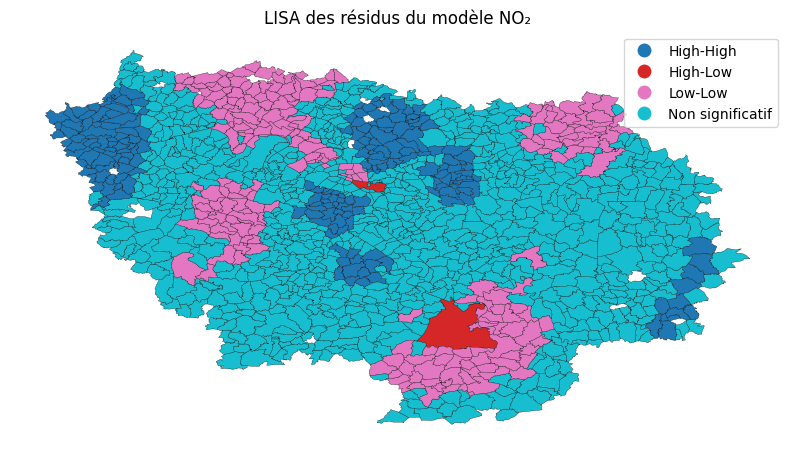

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

communes_idf_short.plot(
    column="lisa_label",
    categorical=True,
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)

ax.set_title("LISA des résidus du modèle NO₂")
ax.axis("off")

plt.show()


La représentation cartographique met en évidence des zones où le modèle OLS sous-estime ou surestime les concentrations de NO2, ainsi que les poches spatiales où les erreurs sont spatialement corrélées. 

Les communes en high-high indiquent que le résidu est élevé dans la commune et que les résidus sont également élevés dans les communes voisines. Donc que le modèle sous-estime systématiquement le NO2 dans cette zone et le sous estime également dans les communes voisines. Donc il existe un facteur local commun non inclus dans le modèle (trafic routier ? Activité industrielle ?)

A l'inverse, les zones low-low indique que le résidu est faible dans la commune et dans les communes voisines. Donc que dans ces zones, le modèle surestime systématiquement le NO2. Cette surestimation est spatialement concentrée.

Les communes high-low indiquent que le résidu est élevé dans la commune/faible dans les communes voisines. Donc que la commune est anormalement plus polluée que ce que prédit le modèle, par rapport aux communes aux alentours, signe d'une spécificité locale. A l'inverse, dans les communes low-high, la commune est moins polluée que prévu, alors qu'elle est entourée de communes où le modèle sous-estime le NO2, signe d'un effet local positif

Dans les communes non significatives, aucune structure spatiale locale n'est détectée.

Ainsi, la visualisation des LISA sur la carte d'Ile-de-France met en évidence des clusters spatiaux significatifs de communes présentant des erreurs de prédiction similaires. Cela confirme la présence d’effets spatiaux locaux non pris en compte par la spécification linéaire initiale et justifie le recours à des modèles économétriques spatiaux plus élaborés qui intègrent les interactions spatiales.